In [34]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import os

In [35]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)

In [36]:
df = pd.read_csv("C:/Users/ebruc/Desktop/ODIR-5K/full_df.csv")

In [37]:
# Function to check if the text contains cataract
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [38]:
# Apply the has_cataract function to create new columns
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))


In [39]:
# Select cataract images
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values


In [40]:
# Select normal images
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250, random_state=seed).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250, random_state=seed).values


In [41]:
# Concatenate cataract and normal images
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)


In [42]:
# Define dataset directory
dataset_dir = "C:/Users/ebruc/Desktop/ODIR-5K/preprocessed_images/"
image_size = 224

In [43]:
# Define labels and dataset arrays
labels = []
dataset = []

In [44]:
# Function to create dataset with images and labels
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue
        
        dataset.append([np.array(image), np.array(label)])
    random.shuffle(dataset)
    return dataset

In [45]:
# Create dataset for cataract images
dataset = create_dataset(cataract, 1)

# Create dataset for normal images
dataset = create_dataset(normal, 0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 273.36it/s]


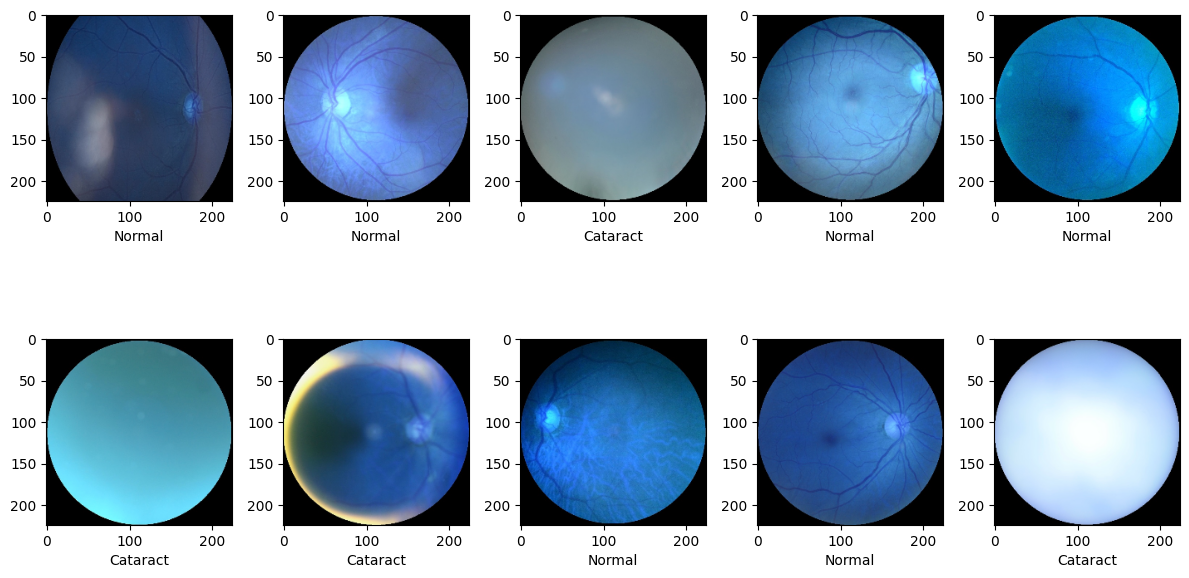

In [46]:
# Visualize sample images
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    label = "Cataract" if category == 1 else "Normal"
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()
plt.show()

In [47]:
# Split dataset into training and testing sets
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.05)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.10)

In [73]:
y_train.shape[0]

929

In [75]:
# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [50]:
# Load pre-trained VGG19 model
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))


In [51]:
# Freeze layers in VGG19 model
for layer in vgg.layers:
    layer.trainable = False


In [52]:
# Create the model architecture
model = Sequential([
    vgg,
    Flatten(),
    Dense(1, activation="sigmoid")
])

In [53]:
# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [54]:
# Define callbacks
checkpoint = ModelCheckpoint("vgg19.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, save_fleq='epoch')

In [55]:
# Fit the model with data generator
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=15, validation_data=(x_val, y_val), callbacks=[checkpoint])

Epoch 1/15
30/30 [==============================] - ETA: 0s - loss: 1.5909 - accuracy: 0.8568
Epoch 1: val_accuracy improved from -inf to 0.94231, saving model to vgg19.h5
30/30 [==============================] - 142s 5s/step - loss: 1.5909 - accuracy: 0.8568 - val_loss: 0.7358 - val_accuracy: 0.9423
Epoch 2/15


C:\Users\ebruc\Desktop\Python\pythonProject\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - ETA: 0s - loss: 1.0583 - accuracy: 0.9096
Epoch 2: val_accuracy did not improve from 0.94231
30/30 [==============================] - 145s 5s/step - loss: 1.0583 - accuracy: 0.9096 - val_loss: 0.4512 - val_accuracy: 0.9423
Epoch 3/15
30/30 [==============================] - ETA: 0s - loss: 0.8030 - accuracy: 0.9322
Epoch 3: val_accuracy did not improve from 0.94231
30/30 [==============================] - 146s 5s/step - loss: 0.8030 - accuracy: 0.9322 - val_loss: 0.4967 - val_accuracy: 0.9327
Epoch 4/15
30/30 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.9225
Epoch 4: val_accuracy did not improve from 0.94231
30/30 [==============================] - 146s 5s/step - loss: 0.6659 - accuracy: 0.9225 - val_loss: 0.5012 - val_accuracy: 0.9231
Epoch 5/15
30/30 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.9225
Epoch 5: val_accuracy improved from 0.94231 to 0.96154, saving model to vgg19.h5
30/30 [====

In [56]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print("loss:", loss)
print("Accuracy:", accuracy)


2/2 [==============================] - 7s 3s/step - loss: 0.4588 - accuracy: 0.9455
loss: 0.4587901830673218
Accuracy: 0.9454545378684998


In [57]:
# Generate predictions
y_pred = (model.predict(x_test) > 0.5).astype("int32")

2/2 [==============================] - 7s 3s/step


In [58]:
# Print classification report and accuracy score
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        24
           1       0.97      0.94      0.95        31

    accuracy                           0.95        55
   macro avg       0.94      0.95      0.94        55
weighted avg       0.95      0.95      0.95        55

Accuracy Score: 0.9454545454545454


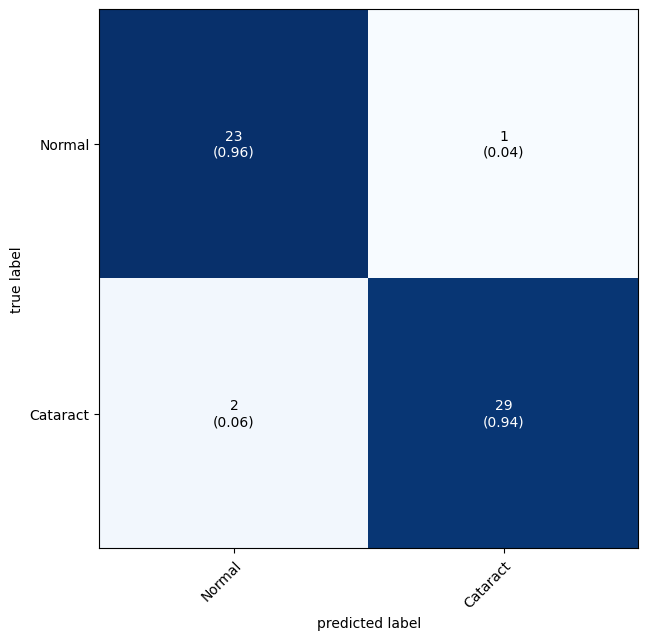

In [59]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=["Normal", "Cataract"], show_normed=True)
plt.show()


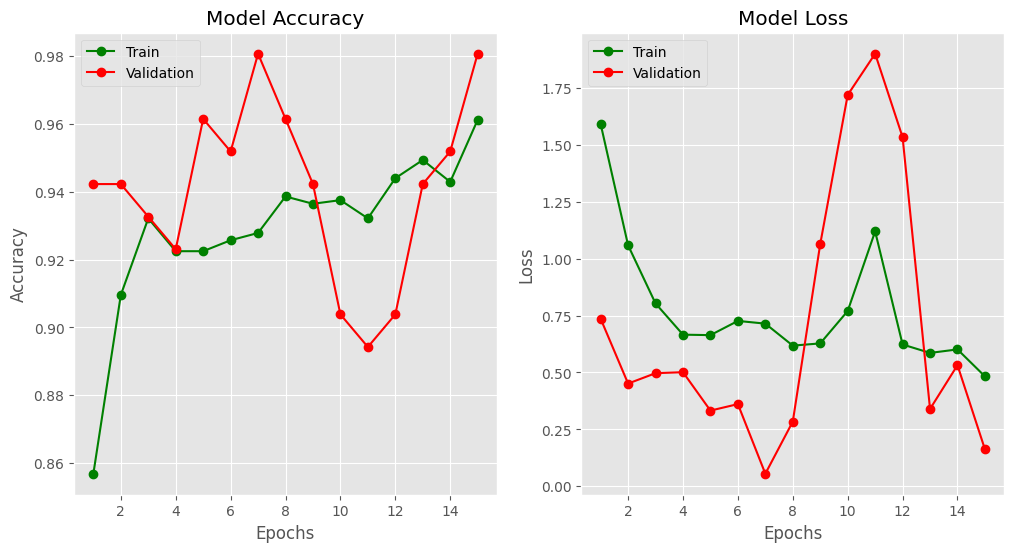

In [61]:
# Plot training history
plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))
epochs = range(1, 16)
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()


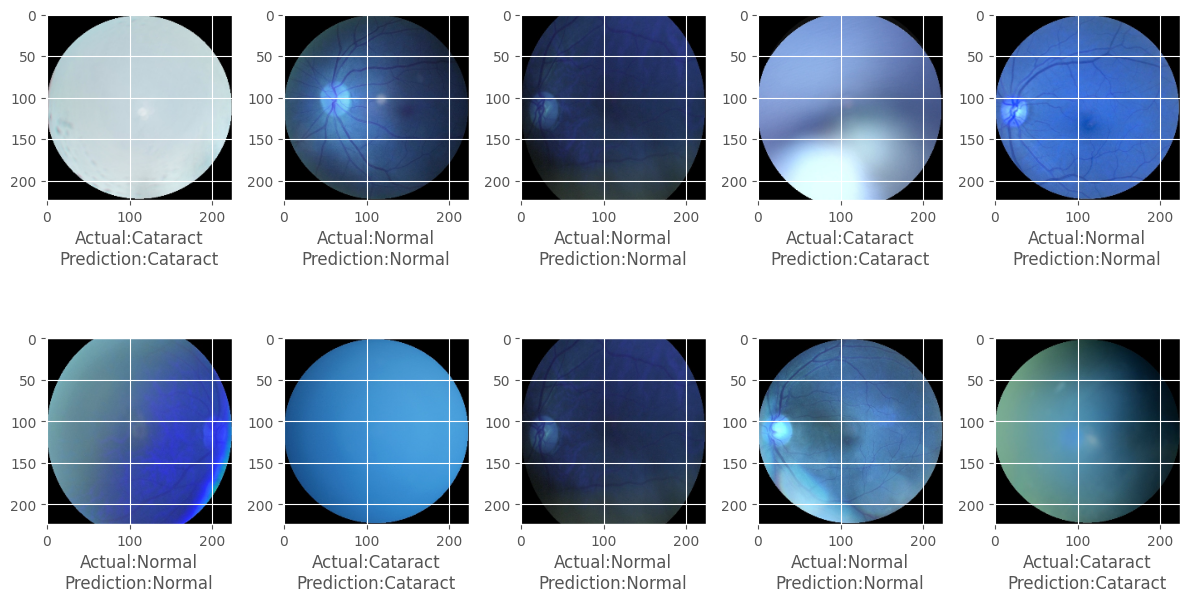

In [66]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 